In [1]:
import os
import sys

sys.path.append(os.getcwd() + "/")

from experiments import setup_experiments

exps = setup_experiments("exp205")

In [2]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

no_bias_dir = Path(exps.path) / "test" / "no_bias"
bias_dir = Path(exps.path) / "test" / "bias"
csv = Path(exps.path) / "test.csv"

no_bias_macaw_cf_dir = Path(exps.path) / "macaw_cfs" / "no_bias"
bias_macaw_cf_dir = Path(exps.path) / "macaw_cfs" / "bias"

df = pd.read_csv(csv, low_memory=True)

In [3]:
macaw_pred_csv = Path(exps.path) / "macaw_cfs" / "no_bias" / "predictions.csv"
macaw_pred_df = pd.read_csv(macaw_pred_csv, low_memory=True)
macaw_pred_dict = dict(zip(macaw_pred_df["filename"], macaw_pred_df["predictions"]))
df["MACAW_SFCN_no_bias"] = df["filename"].map(macaw_pred_dict)

macaw_pred_csv = Path(exps.path) / "macaw_cfs" / "bias" / "predictions.csv"
macaw_pred_df = pd.read_csv(macaw_pred_csv, low_memory=True)
macaw_pred_dict = dict(zip(macaw_pred_df["filename"], macaw_pred_df["predictions"]))
df["MACAW_SFCN_bias"] = df["filename"].map(macaw_pred_dict)

In [4]:
macaw_pred_dict

{'00120_-0.396_S_2.524_D_2_B.tiff': 0.9990898370742798,
 '00115_0.068_S_2.135_D_2_B.tiff': 0.9993706345558168,
 '00139_-0.115_S_-0.69_D_2_B.tiff': 0.9991461038589478,
 '00041_0.68_S_-1.798_D_2_B.tiff': 0.995498538017273,
 '00199_1.075_S_1.712_D_2_B.tiff': 0.9437692165374756,
 '00040_-0.62_S_0.029_D_2_B.tiff': 0.9880372285842896,
 '00131_0.197_S_-0.93_D_2_B.tiff': 0.9991186261177064,
 '00242_-0.086_S_0.392_D_2_B.tiff': 0.9995265007019044,
 '00071_0.351_S_-1.454_D_2_B.tiff': 0.9992377758026124,
 '00020_-0.542_S_-0.187_D_2_B.tiff': 0.9834585189819336,
 '00085_-0.563_S_0.634_D_2_B.tiff': 0.9942814111709596,
 '00000_0.57_S_-0.109_D_2_B.tiff': 0.9987332224845886,
 '00167_1.329_S_0.537_D_2_B.tiff': 0.9201745986938475,
 '00221_-0.109_S_1.494_D_2_B.tiff': 0.9995502829551696,
 '00125_0.079_S_-1.213_D_2_B.tiff': 0.9992637038230896,
 '00237_-1.125_S_-0.109_D_2_B.tiff': 0.6926460862159729,
 '00005_0.38_S_2.515_D_2_B.tiff': 0.9995915293693542,
 '00147_-0.978_S_-1.174_D_2_B.tiff': 0.8533651828765869,

In [5]:
from tifffile import tifffile as tiff


def four_images(idx, df):
    no_bias_img = tiff.imread(
        os.path.join(no_bias_dir, df.iloc[idx]["filename"])
    ).squeeze()
    bias_img = tiff.imread(os.path.join(bias_dir, df.iloc[idx]["filename"])).squeeze()

    no_bias_macaw_cf_img = tiff.imread(
        os.path.join(no_bias_macaw_cf_dir, df.iloc[idx]["filename"])
    ).squeeze()
    bias_macaw_cf_img = tiff.imread(
        os.path.join(bias_macaw_cf_dir, df.iloc[idx]["filename"])
    ).squeeze()

    return no_bias_img, bias_img, no_bias_macaw_cf_img, bias_macaw_cf_img

In [6]:
import numpy as np


def view_images(idx):
    no_bias_img, bias_img, no_bias_macaw, bias_macaw = four_images(idx, df)

    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    [
        a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        for ax in axs
        for a in ax
    ]

    fig.delaxes(axs[0, 4])

    axs[0, 0].imshow(no_bias_img, cmap="gray")
    axs[0, 0].set_title("No bias")

    axs[0, 1].imshow(no_bias_macaw, cmap="gray")
    axs[0, 1].set_title("No bias CF")

    axs[0, 2].imshow(bias_img, cmap="gray")
    axs[0, 2].set_title("Bias")

    axs[0, 3].imshow(bias_macaw, cmap="gray")
    axs[0, 3].set_title("Bias CF")

    # fig.delaxes(axs[1, 0])

    axs[1, 0].imshow(bias_img - no_bias_img, cmap="seismic", clim=(-1, 1))
    axs[1, 0].set_title("Bias - No bias")

    axs[1, 1].imshow(bias_img - no_bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[1, 1].set_title("Bias - No bias CF")

    axs[1, 2].imshow(bias_macaw - no_bias_img, cmap="seismic", clim=(-1, 1))
    axs[1, 2].set_title("Bias CF - No bias")

    axs[1, 3].imshow(no_bias_img - no_bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[1, 3].set_title("No bias - No bias CF")

    axs[1, 4].imshow(bias_img - bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[1, 4].set_title("Bias - Bias CF")

    fig.savefig("results/macaw-diff.pdf", bbox_inches="tight")

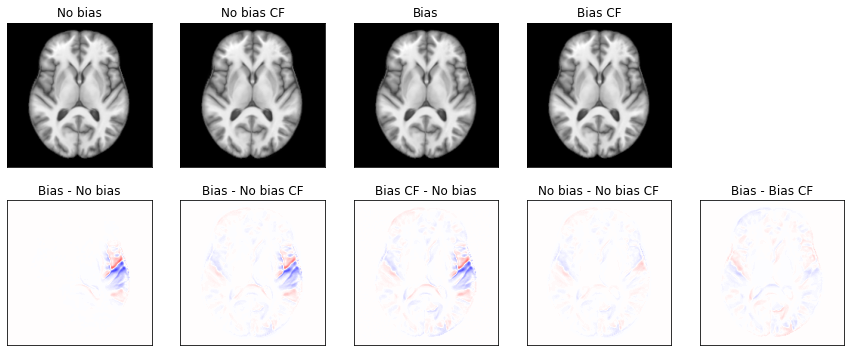

In [63]:
view_images(25)

In [8]:
def TEA(no_bias_img, bias_img, cf_img):
    no_far = (no_bias_img - bias_img).flatten()
    cf_far = (cf_img - bias_img).flatten()

    no_far_mag = np.linalg.norm(no_far)
    cf_far_mag = np.linalg.norm(cf_far)
    projection = no_far.dot(cf_far) / no_far_mag

    effectiveness = projection / no_far_mag
    amplification = np.sqrt(cf_far_mag**2 - projection**2)

    return effectiveness, amplification

In [9]:
n = len(df)

e_remove = []
a_remove = []

e_add = []
a_add = []

for i in range(n):
    no_bias, bias, no_bias_cf, bias_cf = four_images(i, df)

    e, a = TEA(no_bias, bias, no_bias_cf)
    e_remove.append(e)
    a_remove.append(a)

    e, a = TEA(bias, no_bias, bias_cf)
    e_add.append(e)
    a_add.append(a)

df["MACAW_e_remove"] = e_remove
df["MACAW_a_remove"] = a_remove

df["MACAW_e_add"] = e_add
df["MACAW_a_add"] = a_add

In [10]:
df["bias_effect"] = [float(i.split("_")[-2]) for i in df["filename"]]
df["disease_effect"] = [float(i.split("_")[3]) for i in df["filename"]]
df["subject_effect"] = [float(i.split("_")[1]) for i in df["filename"]]
df["isv_dst_abs"] = np.abs(df["isv_dst"])

In [11]:
import seaborn as sns


def sfcn_plot(x, y, hue, data, title):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    intervals = [0.25, 0.5, 0.75]

    viridis_palette = sns.color_palette("icefire", n_colors=11)

    sns.scatterplot(
        x=x,
        y=y,
        hue=hue,
        data=data,
        ax=ax,
        legend="brief",
    )

    # Adding legend with 0.25 interval from 0 to 1
    handles, labels = ax.get_legend_handles_labels()

    ax.legend(
        handles, intervals, title="Pseudo-Oracle logits", ncols=3, loc="upper center"
    )

    ax.set(
        title=title,
        xlabel="Effectiveness",
        ylabel="Amplification",
        ylim=(0, 10),
        xlim=(0.5, 1.2),
    )

    fig.savefig(f"results/{title}.pdf")

In [58]:
import seaborn as sns
import matplotlib.colors as mcolors


def scatter_plot(x, y, hue, data, title, cmap_s, cbar_txt):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Define intervals (bins) and corresponding colors
    boundaries = np.arange(0, 1.1, 0.2)  # Bins: [0, 0.1, 0.2, ..., 1.0]
    colors = sns.color_palette(cmap_s, len(boundaries) - 1)  # Generate N-1 colors

    # Create colormap and normalization
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)

    scatter = sns.scatterplot(
        data=data, x=x, y=y, hue=hue, palette=cmap.reversed(), legend=False
    )

    ax.set(
        title=title,
        xlabel="Effectiveness",
        ylabel="Amplification",
        ylim=(0, 10),
        xlim=(0.5, 1.2),
    )
    # Add custom colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=boundaries)
    cbar.set_label(cbar_txt)

    fig.savefig(f"results/{title}-{cbar_txt}.pdf")

<ipython-input-58-466fa617c07b>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=boundaries)
<ipython-input-58-466fa617c07b>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=boundaries)
<ipython-input-58-466fa617c07b>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, 

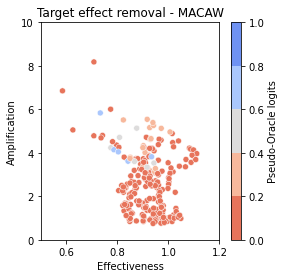

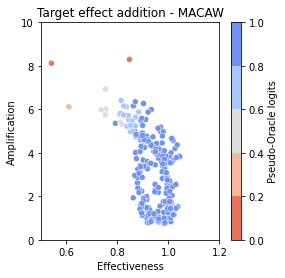

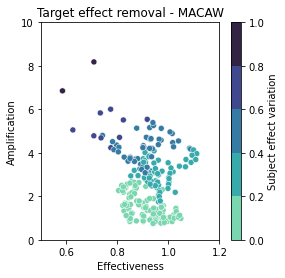

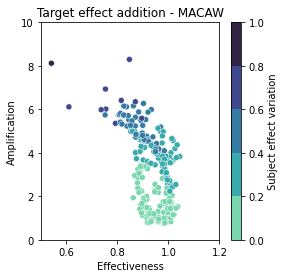

In [60]:
scatter_plot(
    x="MACAW_e_remove",
    y="MACAW_a_remove",
    hue="MACAW_SFCN_no_bias",
    data=df,
    title="Target effect removal - MACAW",
    cmap_s="coolwarm",
    cbar_txt="Pseudo-Oracle logits",
)

scatter_plot(
    x="MACAW_e_add",
    y="MACAW_a_add",
    hue="MACAW_SFCN_bias",
    data=df,
    title="Target effect addition - MACAW",
    cmap_s="coolwarm",
    cbar_txt="Pseudo-Oracle logits",
)

scatter_plot(
    x="MACAW_e_remove",
    y="MACAW_a_remove",
    hue="isv_dst_abs",
    data=df,
    title="Target effect removal - MACAW",
    cmap_s="mako",
    cbar_txt="Subject effect variation",
)


scatter_plot(
    x="MACAW_e_add",
    y="MACAW_a_add",
    hue="isv_dst_abs",
    data=df,
    title="Target effect addition - MACAW",
    cmap_s="mako",
    cbar_txt="Subject effect variation",
)